# Importing libraries and reading in file

In [5]:
!pip install pyspark

  Using cached https://files.pythonhosted.org/packages/f0/26/198fc8c0b98580f617cb03cb298c6056587b8f0447e20fa40c5b634ced77/pyspark-3.0.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/9e/b6/6a4fb90cd235dc8e265a6a2067f2a2c99f0d91787f06aca4bcf7c23f3f80/py4j-0.10.9-py2.py3-none-any.whl
  Running setup.py bdist_wheel for pyspark: started
  Running setup.py bdist_wheel for pyspark: finished with status 'done'
  Stored in directory: C:\Users\Muharramsarwan\AppData\Local\pip\Cache\wheels\5e\bd\07\031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [196]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import NGram,HashingTF, IDF
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import lit
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Word2Vec
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark import SparkContext

if __name__ == "__main__":
    spark = SparkSession\
        .builder\
        .appName("Detecting-Malicious-URL App")\
        .getOrCreate()

#Reading in the URL file and storing into dataframe
data_df = spark.read.csv(path='dataset.csv',
                        sep=',',
                        encoding='UTF-8',
                        comment=None,
                        header=True, 
                        inferSchema=True)

data_df.groupby('label').count().toPandas()

,label,count
0,1,56937
1,0,1000000


# Under Sample Unbalanced Datasets

In [197]:

malicious = data_df.filter("label = 1")
bening = data_df.filter("label = 0")

#malicious.count()
#bening.count()

sampleRatio = malicious.count() / data_df.count()
#print("sampleRatio: %g" %sampleRatio)
sample_bening = bening.sample(False, sampleRatio)

sampled = malicious.unionAll(sample_bening)

sampled.groupby('label').count().toPandas()



,label,count
0,1,56937
1,0,53840


# Data Ingestion and Vectorization

In [198]:
#Tokennize the TrainData - sparse the URL string into words
regexTokenizer = RegexTokenizer(inputCol="url", outputCol="Words", pattern="\\W")

#CountVectorizer converts the the words into feature vectors - Thi is used as it gives better results
countVectors = CountVectorizer(inputCol=regexTokenizer.getOutputCol(), outputCol="rawfeatures", vocabSize=10000, minDF=5)

#
idf = IDF(inputCol=countVectors.getOutputCol(), outputCol="features") 

#create the pipline 
pipeline = Pipeline(stages=[regexTokenizer, countVectors, idf ])


# Fit the pipeline to training documents.
# Pass 'sampled' in the param to set Balanced datasets
pipelineFit = pipeline.fit(sampled)

#Transform the pipeline to dataset
# Pass 'sampled' in the param to set Balanced datasets
dataset = pipelineFit.transform(sampled)

#randomly split the dataset to traning and testing 80%, 20% respectively
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
print("\nTraining Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
print("Total Dataset Count: " + str(dataset.count()))

dataset.show(5)


Training Dataset Count: 88478
Test Dataset Count: 22299
Total Dataset Count: 110777
+--------------------+-----+--------------------+--------------------+--------------------+
|                 url|label|               Words|         rawfeatures|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|http://br-ofertas...|    1|[http, br, oferta...|(6951,[0,1,2,3,18...|(6951,[0,1,2,3,18...|
|https://semana-da...|    1|[https, semana, d...|(6951,[0,3,6,18,1...|(6951,[0,3,6,18,1...|
|https://scrid-app...|    1|[https, scrid, ap...|(6951,[0,6,842],[...|(6951,[0,6,842],[...|
|http://my-softban...|    1|[http, my, softba...|(6951,[0,1,29,161...|(6951,[0,1,29,161...|
|http://www.my-sof...|    1|[http, www, my, s...|(6951,[0,1,4,29,1...|(6951,[0,1,4,29,1...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [199]:
trainingData.groupby('label').count().toPandas()

,label,count
0,1,45609
1,0,42869


In [200]:
testData.groupby('label').count().toPandas()

,label,count
0,1,11328
1,0,10971


# Linear Support Vector Machine

Precision: 97.5232
Recall: 99.7721
f1-Score: 98.6413
Total: 22299

Accuracy: 98.6412


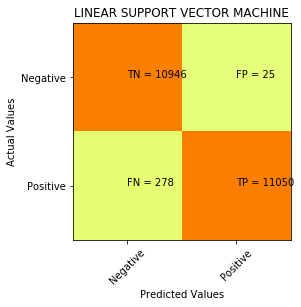

In [201]:
#==============[ Linear Support Vector Machine ]=====================

for i in range(1, 2):
    
    lsvc = LinearSVC(maxIter=10, regParam=0.3)

    # Fit the model
    lsvcModel = lsvc.fit(trainingData)

    predictions = lsvcModel.transform(testData)

    # Select (prediction, true label) and compute test error
#     evaluator = RegressionEvaluator(
#         labelCol="label", predictionCol="prediction", metricName="rmse")
#     rmse = evaluator.evaluate(predictions)
#     print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

    svm_evaluatorrecall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
    svm_recall = svm_evaluatorrecall.evaluate(predictions)

    svm_evaluatorprecision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
    svm_precision = svm_evaluatorprecision.evaluate(predictions)

    svm_evaluatorf1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    svm_f1 = svm_evaluatorf1.evaluate(predictions)

    svm_evaluatoraccurasy = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy")
    svm_accuracy = svm_evaluatoraccurasy.evaluate(predictions)

    print("Precision: %g" % (svm_precision*100))
    print("Recall: %g" % (svm_recall*100))
    print("f1-Score: %g" % (svm_f1*100))
    print("Total: %g" % (predictions.count()))
    print("\nAccuracy: %g" % (svm_accuracy*100))
    
    #==================[ Confusing Matrix Calculation and Plotting ]
    lsvm_predictions = lsvcModel.transform(testData)


    y_actu = lsvm_predictions.select("label").toPandas()
    y_pred = lsvm_predictions.select("prediction").toPandas()

    cm = confusion_matrix(y_actu, y_pred)

    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('LINEAR SUPPORT VECTOR MACHINE')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    s = [['TN','FN'], ['FP', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(i,j, str(s[i][j])+" = "+str(cm[j][i]))
    plt.show()

# Random Forest

Precision: 99.9628
Recall: 94.8535
f1-Score: 97.3669
Total: 22299

Accuracy: 97.3676


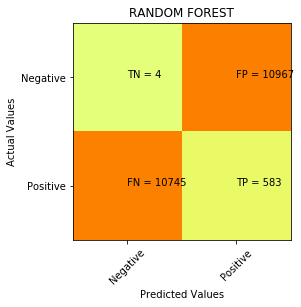

In [203]:
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(dataset)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(dataset)

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
rf_pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
rf_model = rf_pipeline.fit(trainingData)

# Make predictions.
rf_predictions = rf_model.transform(testData)

rf_evaluatorrecall = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="recallByLabel")
rf_recall = rf_evaluatorrecall.evaluate(rf_predictions)

rf_evaluatorprecision = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="precisionByLabel")
rf_precision = rf_evaluatorprecision.evaluate(rf_predictions)

rf_evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
rf_f1 = rf_evaluatorf1.evaluate(rf_predictions)

rf_evaluatoraccurasy = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
rf_accuracy = rf_evaluatoraccurasy.evaluate(rf_predictions)

print("Precision: %g" % (rf_precision*100))
print("Recall: %g" % (rf_recall*100))
print("f1-Score: %g" % (rf_f1*100))
print("Total: %g" % (rf_predictions.count()))
print("\nAccuracy: %g" % (rf_accuracy*100))

#==================[ Confusing Matrix Calculation and Plotting ]
rf_predictionss = rf_model.transform(testData)


y_actual = rf_predictionss.select("label").toPandas()
y_predicted = rf_predictionss.select("prediction").toPandas()

rf_cm = confusion_matrix(y_actual, y_predicted)

plt.clf()
plt.imshow(rf_cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('RANDOM FOREST')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

rf_s = [['TN','FN'], ['FP', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(i,j, str(rf_s[i][j])+" = "+str(rf_cm[j][i]))
plt.show()

# Source : https://github.com/rlilojr/Detecting-Malicious-URL-Machine-Learning 